### Using the nanotube profiles to build a matched filter bank

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('/Users/nik/Dropbox/Notebooks/thesisrc.py')
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

from scipy import ndimage 
from skimage import io, img_as_float
from skimage.transform import rotate

import pickle
import os, glob, shutil, random

In [2]:
img_dir = '/Users/nik/Dropbox/cnt_filter/original'
test_dir = '/Users/nik/Dropbox/cnt_filter/test'
fig_dir = '/Users/nik/Dropbox/Repos/thesis/figures/chapter3'
os.chdir(test_dir)

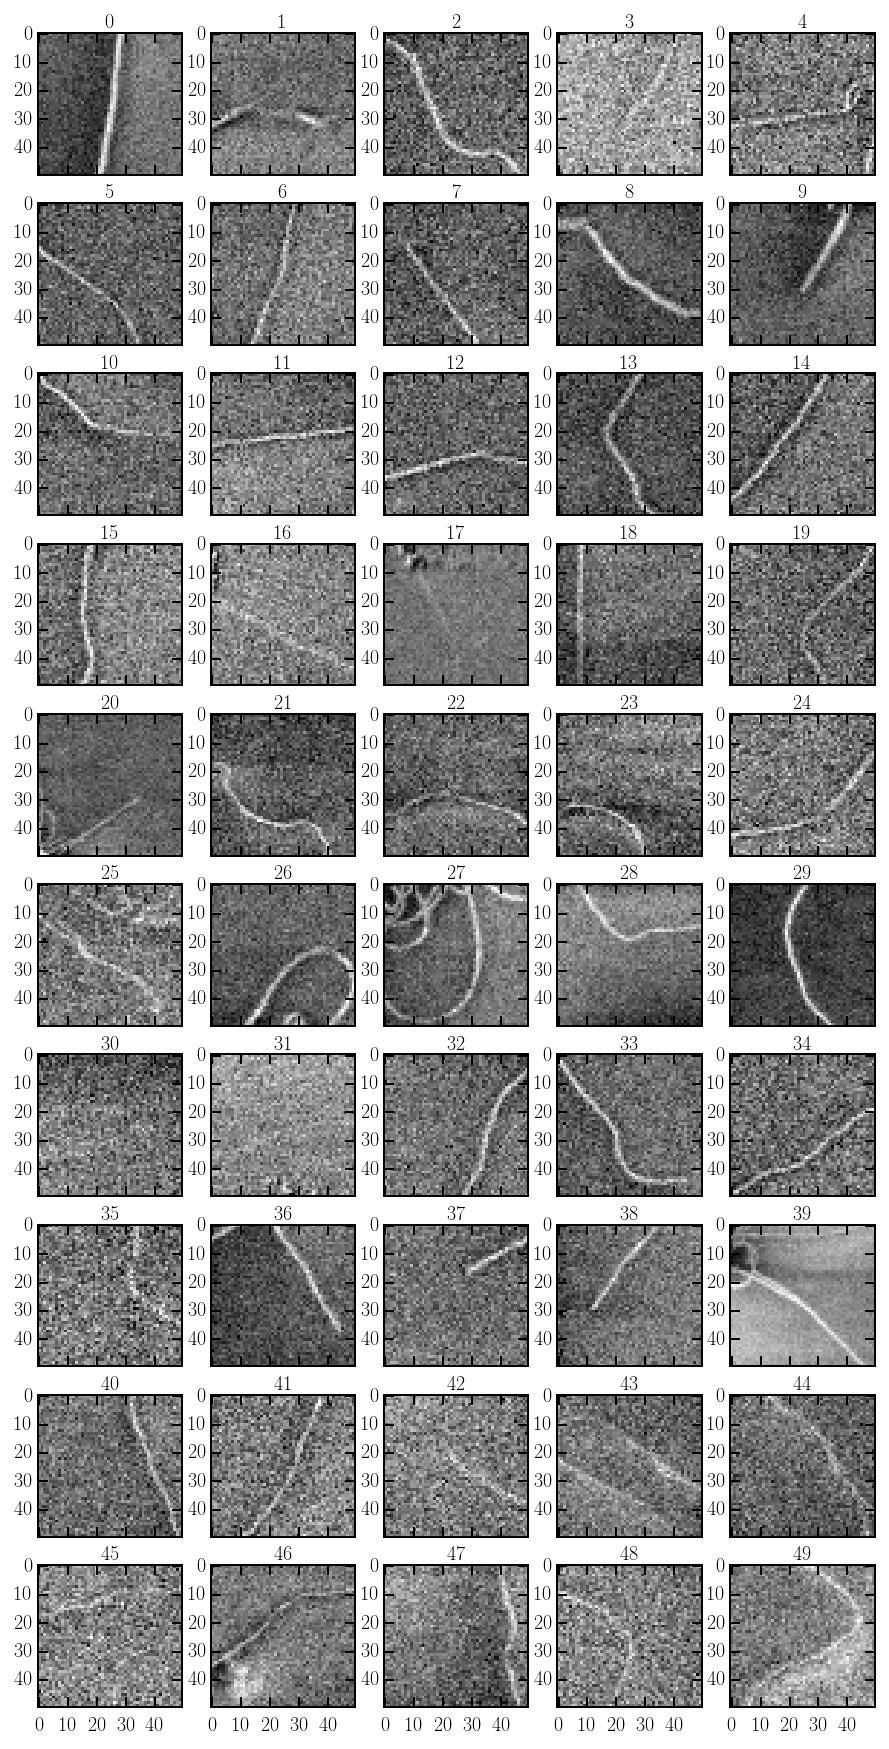

In [3]:
# plot the data set that I'm working with

# make sure all images match the output of 'img_as_float'

tubes = img_as_float(np.load('individual_cnt_imgs.npy'))

fig, axs = plt.subplots(10,5,sharex = True, sharey=False, 
                        figsize=(5*3,10*3))
axs = axs.flat

for i, im in enumerate(tubes):
    axs[i].imshow(im, aspect = 'auto', interpolation = 'None')
    axs[i].set_title(i)

In [4]:
# two possible fitting functions for the profiles 
# x should be an array with an odd number of elements and zero in the middle

def sinc(x, k, a):
    """ return a sinc function cutoff at +/-2*pi/a """
    
    iz = int(len(x)/2)
    il = iz-np.ceil(2.0*np.pi/k)
    iu = iz+np.ceil(2.0*np.pi/k)+1
    
    s = np.sin(k*x)/(k*x) # function to start with
    s[iz] = 1 # numpy doesn't know about limits
    s[il:iu] -= s[il:iu].mean()
    s[0:il] = 0; s[iu:] = 0
    return a*s

def triangle(x, k, a):
    """ return just a triangular shaped peak with bottom width, k """
    
    iz = int(len(x)/2)
    il = iz-np.floor(k/2.0)
    iu = iz+np.floor(k/2.0)+1
    
    s1 = (2.0/k)*x[0:iz] + 1
    s2 = (-2.0/k)*x[iz:] + 1
    
    s = np.append(s1,s2)
    s[il:iu] -= s[il:iu].mean()
    s[0:il] = 0; s[iu:] = 0
    return a*s

In [5]:
def build_kernel(func, N, k, a, L):
    """ N is an odd integer. The kernel will be size NxN with (x,y) = (0,0)
        in the center. """
    x = np.arange(-(N/2),(N/2)+1,1)
    f = func(x, k, a)
    #func(np.arange(-(N/2),(N/2)+1,1), k, a)
    #kernel = np.zeros((N,N), dtype='uint8')
    #kernel = np.zeros((N,N), dtype='uint16')
    kernel = np.zeros((N,N), dtype = np.float)
    kernel[abs(x)<L/2.0, :] = f
    return kernel

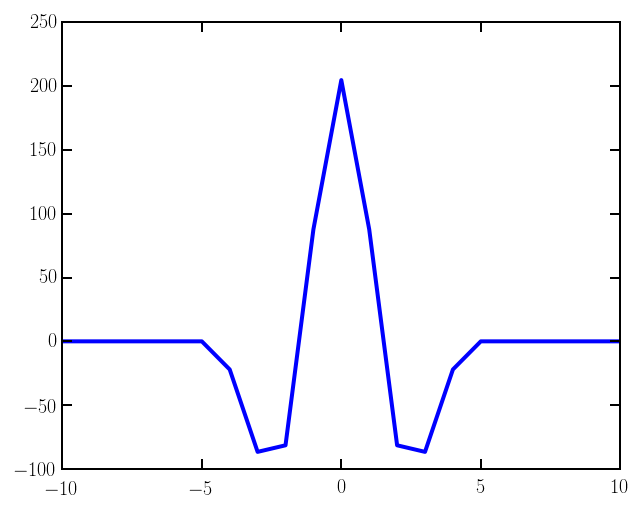

In [11]:
N = 21
x = np.arange(-(N/2),(N/2)+1,1)
# f = triangle(x, 5, 255)
s = sinc(x, 1.8, 255)
plt.plot(x, s)

In [7]:
# build up a test from one of the rotated images
angles = pickle.load( open( "cnt_angles.p", "rb" ) )

Here's a test of the vertical filter (theta = 0.0)

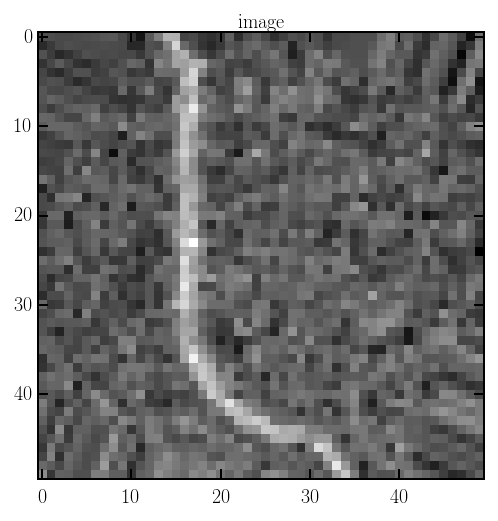

In [8]:
imtest = rotate(tubes[2], angles[2], resize=False, mode='nearest')
plt.imshow(imtest, cmap = plt.cm.gray, interpolation='none')
plt.title('image')

<matplotlib.colorbar.Colorbar instance at 0x113022878>

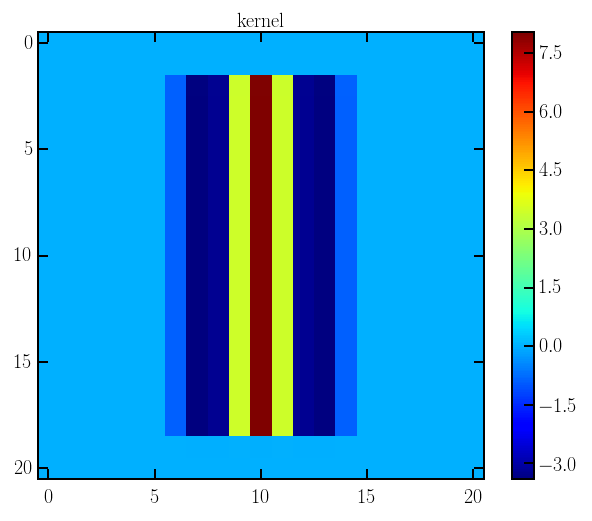

In [10]:
kernel = build_kernel(sinc,21,1.8,10,18)
plt.imshow(kernel, interpolation='none', cmap=plt.cm.jet)
plt.title('kernel')
plt.colorbar()

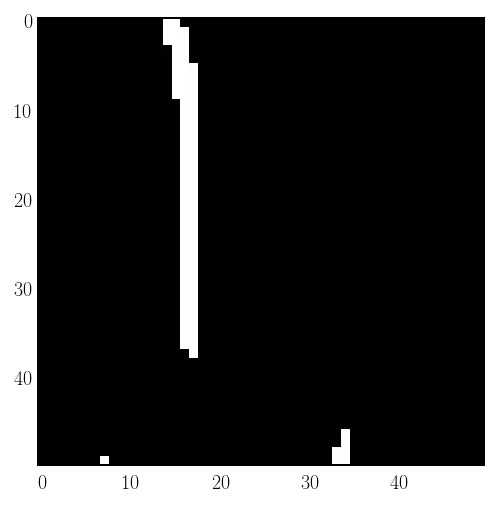

In [22]:
imfilt = ndimage.convolve(imtest, kernel, mode='nearest')
threshold = 5
plt.imshow(imfilt>threshold, cmap = plt.cm.gray, interpolation='none')

Awesome. There's some strange stuff going on with the scaling here. To be consistent:

+ imread yields uint8 arrays from the tiff files
+ the image in convolve should match the output of img_as_float ('float64' from 0 to 1)
+ the scaling, a, of the kernel should be empirically determined, I have no idea how
+ the width of the kernel, k, should be empirically determined starting with the range of test values in the nanotube_profile notebook
+ the length of the kernel, L, should be empirically determined starting with the range of test values in the nanotube_profile notebook

Let's see if I can duplicate that by rotating the filter, not the image.

<matplotlib.colorbar.Colorbar instance at 0x1147eeb90>

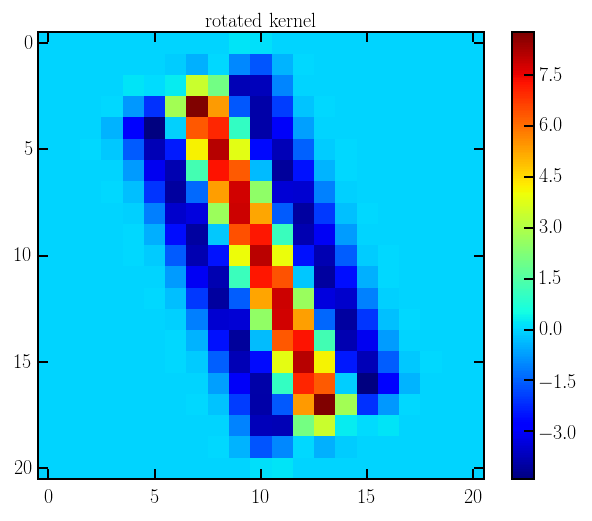

In [24]:
imtest = tubes[2]
kernel = build_kernel(sinc,21,1.8,10.0,18)
kernel = ndimage.rotate(kernel, 22, reshape=False, mode='nearest') # this has a lot fewer type problems than skimage
plt.imshow(kernel, interpolation='none', cmap=plt.cm.jet)
plt.title('rotated kernel')
plt.colorbar()

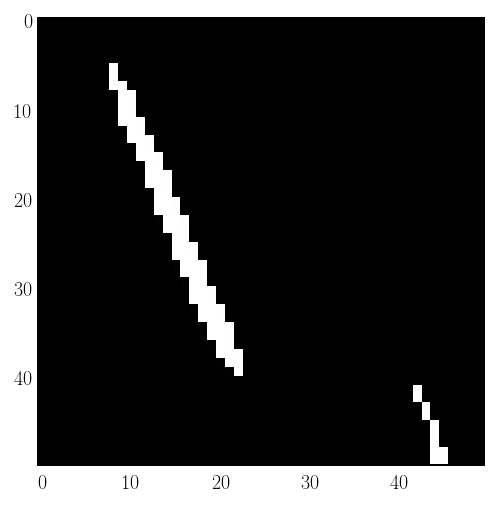

In [25]:
imfilt = ndimage.convolve(imtest, kernel, mode='nearest')
threshold = 5.0
plt.imshow(imfilt>threshold, interpolation='none')

Blammo!

Now build the filter bank.

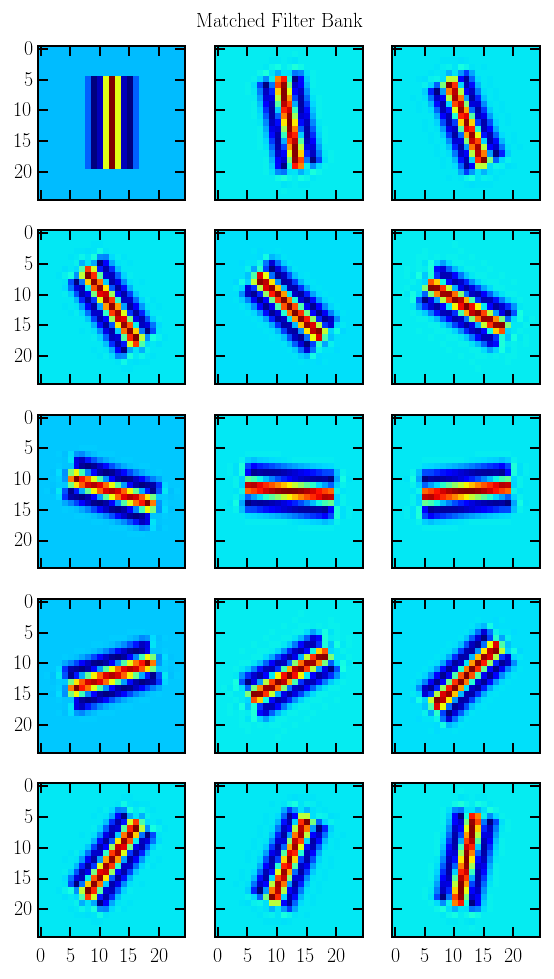

In [70]:
rotations = np.arange(0,180,12, dtype=np.float)

fig, axs = plt.subplots(5,3,sharex = True, sharey=True,
                        figsize=(3*3,5*3))
axs = axs.flat

N = 25
fbank = np.zeros((len(rotations),N,N))
kernel = build_kernel(sinc,N,1.75,10.0,16)
for i, r in enumerate(rotations):
    fbank[i] = ndimage.rotate(kernel, r, reshape=False, mode='nearest')
    axs[i].imshow(fbank[i], aspect = 'auto', interpolation='nearest', cmap=plt.cm.jet)
fig.suptitle('Matched Filter Bank')
fig.subplots_adjust(top=0.95)
fig.savefig(os.path.join(fig_dir, 'matched_filter_bank.pdf'), format='pdf', dpi=300)
#fig.tight_layout()

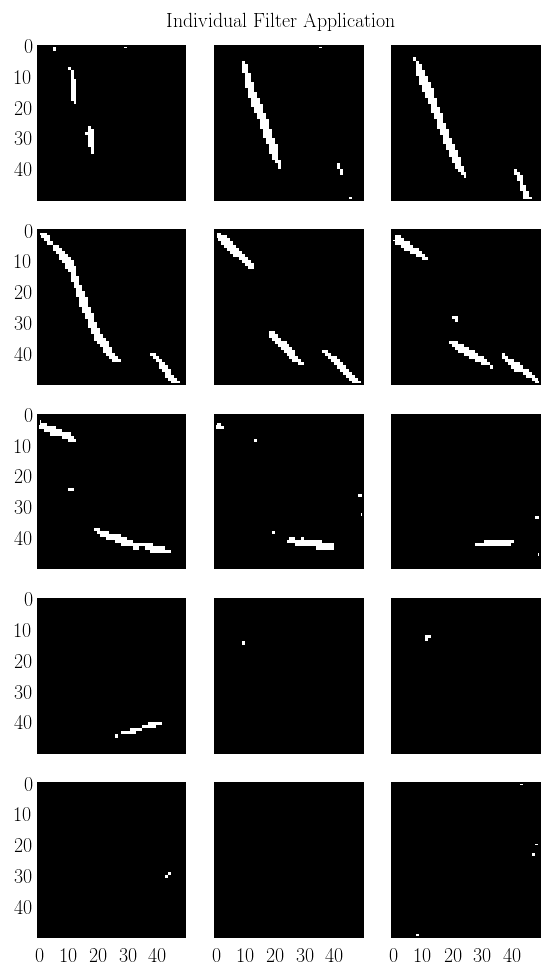

In [71]:
imtest = tubes[2]

fig, axs = plt.subplots(5,3,sharex = True, sharey=True, 
                        figsize=(3*3,5*3))
axs = axs.flat

threshold=3.6
result = np.zeros((50,50))
for i, f in enumerate(fbank):
    imfilt = ndimage.convolve(imtest, fbank[i], mode='nearest')
    axs[i].imshow(imfilt>threshold, plt.cm.gray, aspect = 'auto', interpolation='nearest')
    result += imfilt>threshold
fig.suptitle('Individual Filter Application')
fig.subplots_adjust(top=0.95)
fig.savefig(os.path.join(fig_dir, 'applied_filter_bank.pdf'), format='pdf', dpi=300)

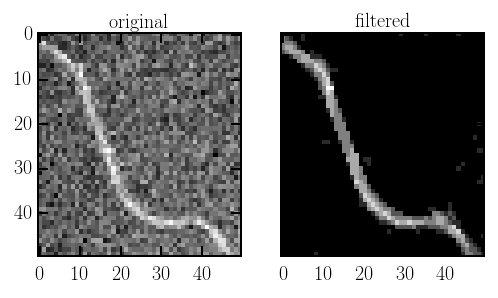

In [72]:
fig, axs = plt.subplots(1,2,sharex = True, sharey=True,
                        figsize=(2*4,1*4))

axs[0].imshow(tubes[2], interpolation='nearest', aspect='auto')
axs[0].set_title('original')
axs[1].imshow(result, interpolation='nearest', aspect='auto')
axs[1].set_title('filtered')

# fig.suptitle('Results')
# fig.subplots_adjust(top=0.9)
fig.savefig(os.path.join(fig_dir, 'filter_bank_results.pdf'), format='pdf', dpi=300)

That's with pretty much zero optimization of k, a, L, N, threshold, or number of filters (threshold and a are not independent)

In [36]:
# use this filter bank to filter all 50 test images
# identify about 5 to use to optimize the filter in another notebook

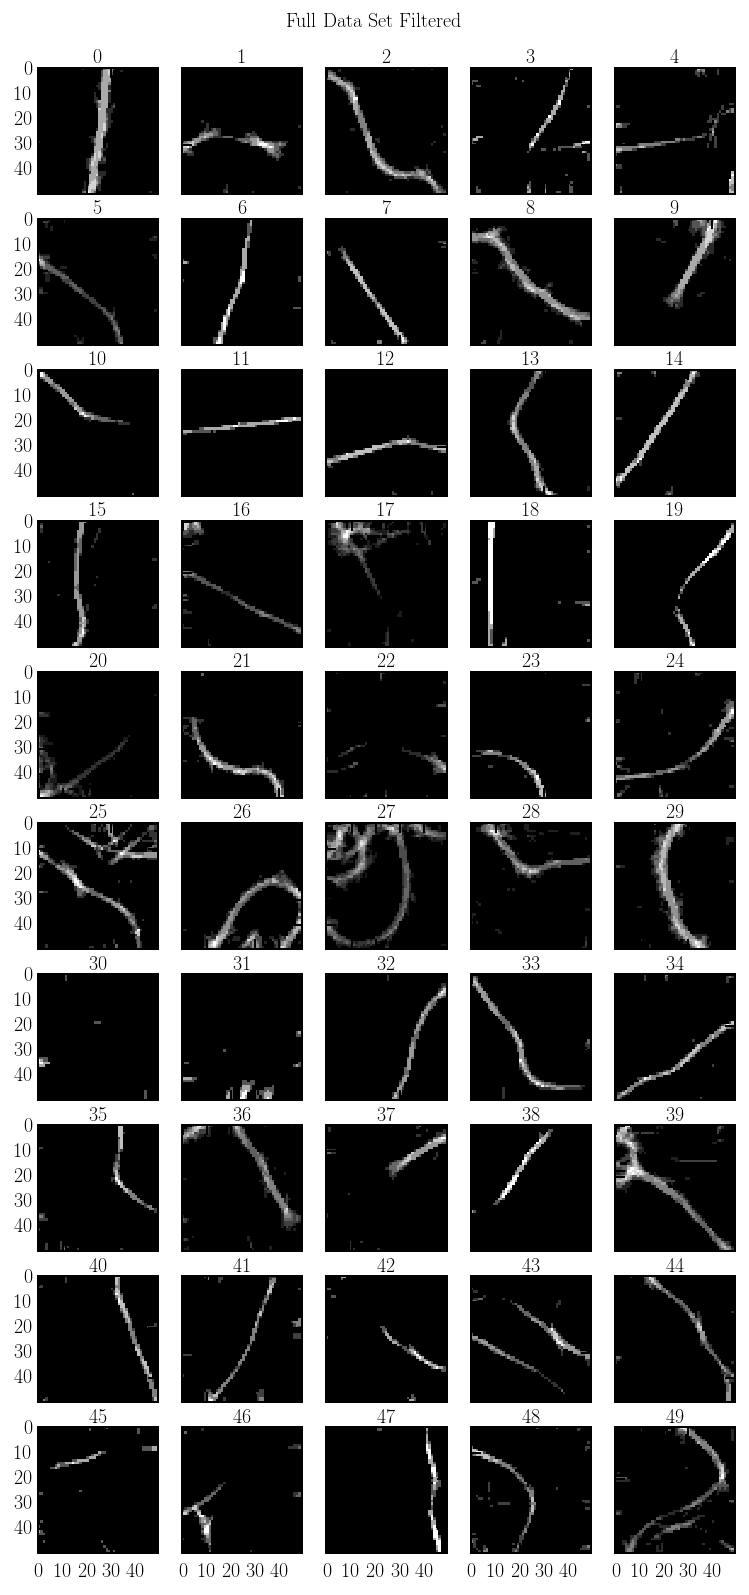

In [77]:
fig, axs = plt.subplots(10,5,sharex = True, sharey=True, 
                        figsize=(5*2.5,10*2.5))
axs = axs.flat

threshold=3.6
for i, im in enumerate(tubes):
    result = np.zeros((50,50))
    for fb in fbank:
        imfilt = ndimage.convolve(im, fb, mode='nearest')
        result += imfilt>threshold
    axs[i].imshow(result, cmap = plt.cm.gray, aspect = 'auto', interpolation = 'nearest')
    axs[i].set_title(i)
fig.suptitle('Full Data Set Filtered')
fig.subplots_adjust(top=0.95)
fig.savefig(os.path.join(fig_dir,'nanotube_all_filtered.pdf'), format='pdf', dpi=300)

In [ ]:
# subset of test to use to calibrate filter
# 0  - because it is noisy around the tube
# 3  - because of the noise at the edges
# 19 - because it is disconnected and shouldn't be
# 27 - because it has many tubes
# 48 - because it is noisy away from the tube